# Week 9 




<div style="color:blue;font-style:italic">28.02.2022 - 04.03.2022 </div>


<div style="background-color:rgba(256, 76, 76,0.4)",height="200">

<br>

<H4>Abstract</H4>

<br>

</div>

---

While Bayesian statistics provide deep insights into the parameter space of a certain model, a major drawback are the long execution times. When the same bayesian model is fit to multiple datasets, parallelization of the sampling step might help overcome this drawback. Graphical Processing Units offer an oppertunity to parallelize a large amount of tasks, making attempts to sample a set of models simultanously on a GPU an interesting experiment. The developers of pymc recently implemented a jax backend making it possible to run Nuts on the GPU.

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Introduction</H4>
<br>
</div>

---


After developing on methods for feature extraction from data-dependent-acquisition datasets, the next step in a prototype pipeline for a bayesian precursor feature analysis is the data transfer to the model. Bayesian statistics provide deep insights in the
possible parameters of a model, however this comes with rather long sampling runtimes. But since the evaluation of two features can be performed independently, parallelization might help overcome this drawback. Nevertheless we need to keep in mind, that 
the evaluation of a single feature necessarily gives rise to multiple threads corresponding to the number of chains used for convergence control <cite data-cite="GelmanRubin92"></cite>. It is obvious that running multiple feature evaluations parallely - each running e.g. 4 chains parallely - quickly pushes the typical workstation CPU to it's limits. However graphical processing units (GPU) might be of help here, since they employ a significant higher number of processing cores (e.g.The here used Geforce GTX 1080Ti employing 3584 CUDA cores <cite data-cite="NvidiaGTX1080Ti"></cite>).
Fitting many models at once on a GPU might speed up the sampling process signifincantly.







---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Methods and Material</H4>
<br>
</div>

---


The probabilistic models are written with the probabilistic programming library PyMC <cite data-cite="pymc3"></cite>. The PyMC developers recently reported a sampling speed up by employing the GPU with pre-release PyMC v4 <cite data-cite="pymcGPU"></cite>. 
PyMC v4 comes with a jax backend allowing for sampling bayesian models with numpyro's No-U-Turn sampler (NUTS) implementation on the GPU <cite data-cite="jax,numpyro"></cite> .

Since parallel sampling of many isntances of the same model on the GPU currently seemed not to be straightforward, a artificial parallelization was accomplished by building a PyMC model, that is spanning n submodels. Each submodel is an instance of the model of interest and is independent of each other submodel. The input data is shaped accordingly. 

As an minimal model example the inference of the mean of a normal distribution was employed (<b>Fig.1</b>):

```python3
with pm.Model() as model:
    data = pm.Data("data", obs_data[0])
    mus = pm.Normal("mus",0,20,shape=d2)
    normals = [pm.Normal(f"obs_{i}",mu = mus[i],sigma=1,\
    observed=data.get_value()[i]) for i in range(d2)]
```
To assay the runtime behaviour over time a total of 640 datasets were created with 10 and 20 datapoints each. These datasets were apssed to the artificial modelset with increasing degree of parallelization. The tested numbers of submodels were 1,10,20,40,80,160,320 and 640, i.e. in the first case all datasets were regarded sequentially and in the last case parallely. For both CPU and GPU execution the runtimes were recorded. 

Python scripts for CPU and GPU samping can be downloaded ([CPU](data/pymcCPUtest.py) and [GPU](data/pymcGPUtest.py)).

Due to crashing CPU execution in PyMC v4, CPU python program was executed with PyMC v3.

---

<div style="background-color:white">

<img src="data/modelGraphviz.svg" >

</div>
<figcaption style="font-weight:bold;font-size:small">
Fig 1: Visualization of artificial Model spanning 10 submodels each receiving an independent dataset of normally distributed data of unknown mean. Visualization was created with python-graphviz <cite data-cite="graphviz"></cite>.
</figcaption>

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Results</H4>
<br>
</div>

---
Recorded runtimes were stored in csv format. 
First, these are loaded:

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")

Datasets with 10 datapoints in eachs set:

In [ ]:

CPU = pd.read_csv("data/dataCPUD310.csv",index_col=0)
GPU = pd.read_csv("data/dataGPUD310.csv",index_col=0)


Datasets with 20 datapoints in each set:
(GPU broke here, has yet to be done)

In [ ]:
CPUD20 = pd.read_csv("data/dataCPUD320.csv",index_col=0)


Number of submodels are stored in D2.

In [12]:
submodel_n = GPU.D2

Plot the runtimes vs. the number of submodels (<b>Fig.2</b>). Since the runtime for submodel_n = 1 case is very high, <b>Fig.3</b> cuts the submodel_n = 1 case off. 

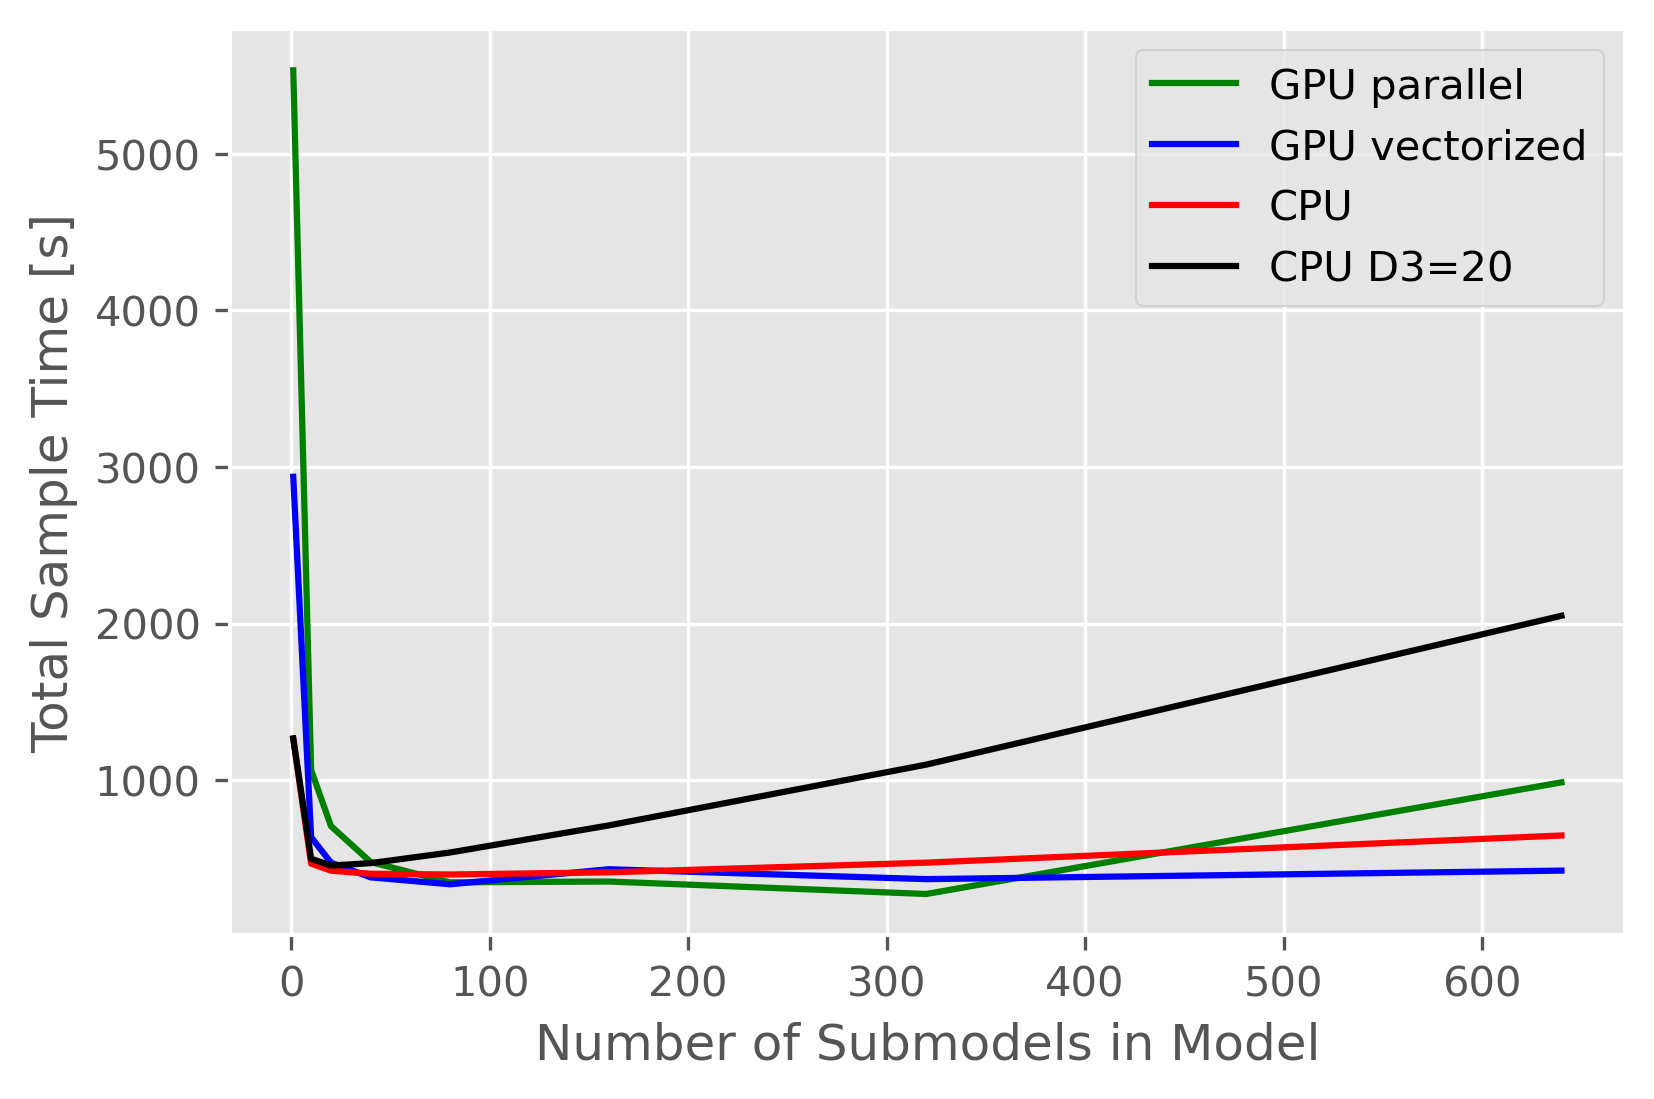

In [13]:

Fig2, ax2 = plt.subplots()
Fig2.set_dpi(300)
ax2.plot(submodel_n,GPU.GPU_times,label="GPU parallel",color="green")
ax2.plot(submodel_n,GPU.GPUv_times,label="GPU vectorized",color="blue")
ax2.plot(submodel_n,CPU.CPU_times,label="CPU",color="red")
ax2.plot(submodel_n,CPUD20.CPU_times,label="CPU D3=20",color="black")
ax2.set_xlabel("Number of Submodels in Model")
ax2.set_ylabel("Total Sample Time [s]")
ax2.legend()
plt.show()


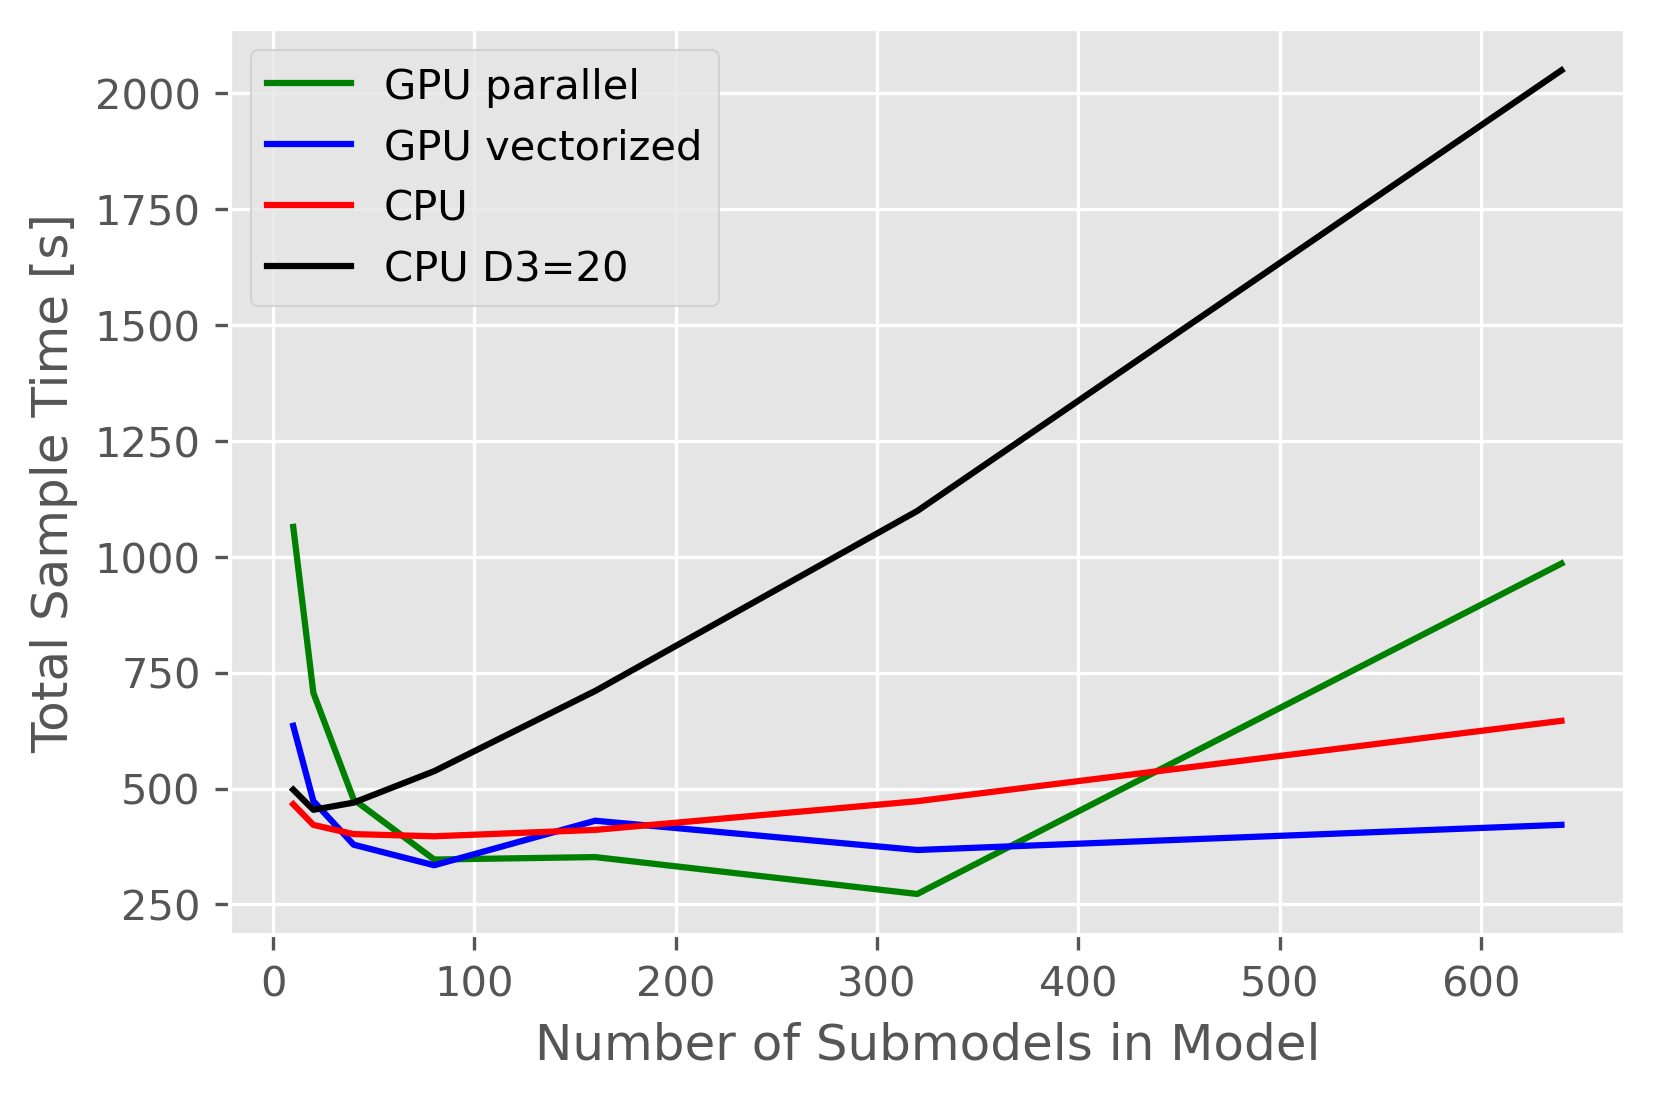

In [14]:

Fig3, ax3 = plt.subplots()
Fig3.set_dpi(300)
ax3.plot(submodel_n[1:],GPU.GPU_times[1:],label="GPU parallel",color="green")
ax3.plot(submodel_n[1:],GPU.GPUv_times[1:],label="GPU vectorized",color="blue")
ax3.plot(submodel_n[1:],CPU.CPU_times[1:],label="CPU",color="red")
ax3.plot(submodel_n[1:],CPUD20.CPU_times[1:], label="CPU D3=20",color="black")
ax3.set_xlabel("Number of Submodels in Model")
ax3.set_ylabel("Total Sample Time [s]")
ax3.legend()
ax3.set_title("")
plt.show()


<b> Fig.4</b> shows model build times.

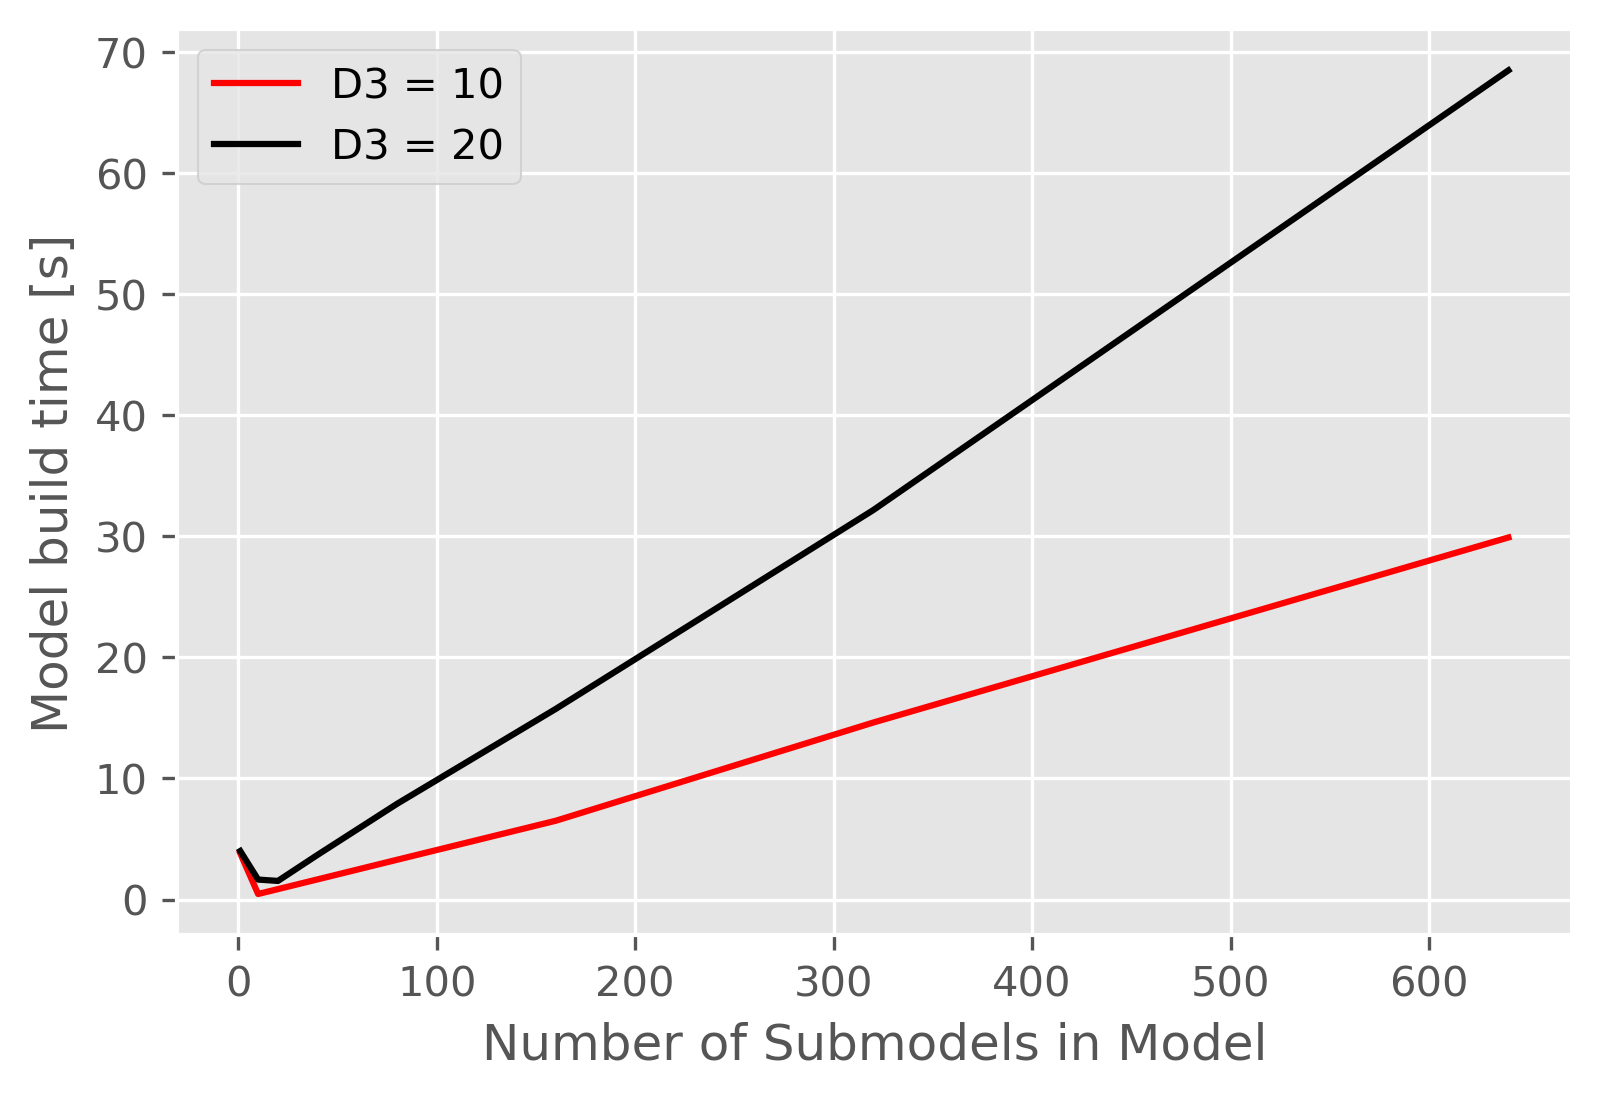

In [17]:
Fig4,ax4 = plt.subplots()
Fig4.set_dpi(300)
ax4.plot(submodel_n,CPU.Model_build_times,color="red",label="D3 = 10")
ax4.plot(submodel_n,CPUD20.Model_build_times,color="black",label="D3 = 20")
ax4.set_xlabel("Number of Submodels in Model")
ax4.set_ylabel("Model build time [s]")
ax4.legend()
plt.show()

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Conclusion and Outlook</H4>
<br>
</div>


---

Lorem ipsum....



---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>References</H4>
<br>
</div>


---

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>To Do</H4>
<br>
</div>


---

Next Steps:

1. Parallelized GLM model
2. Model Evaluation for GLM in pystoms
3. Feature Manager -> handling many features at once
4. Test Model on GPU

5. CPU and GPU breakdown for bigger models in pymc4







---